# Recommender system on Steam Dataset using LightFM model

Almaz Dautov, Damir Abdulayev, DS21-02

a.dautov@innopolis.university

d.abdulayev@innopolis.university

This notebook explains the concept of a hybrid matrix factorisation based model for recommendation, it also outlines the steps to construct a pure matrix factorisation and a hybrid models using the [LightFM](https://github.com/lyst/lightfm) package.

### LightFM package 

LightFM is a Python implementation of a hybrid recommendation algorithms for both implicit and explicit feedbacks [1].

It is a hybrid content-collaborative model which represents users and items as linear combinations of their content features’ latent factors. The model learns **embeddings or latent representations of the users and items in such a way that it encodes user preferences over items**. These representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.

The user and item embeddings are estimated for every feature, and these features are then added together to be the final representations for users and items. 

#### Modelling approach

Let $U$ be the set of users and $I$ be the set of items, and each user can be described by a set of user features $f_{u} \subset F^{U}$ whilst each items can be described by item features $f_{i} \subset F^{I}$. Both $F^{U}$ and $F^{I}$ are all the features which fully describe all users and items. 

The LightFM model operates based binary feedbacks, the ratings will be normalised into two groups. The user-item interaction pairs $(u,i) \in U\times I$ are the union of positive (favourable reviews) $S^+$ and negative interactions (negative reviews) $S^-$ for explicit ratings. For implicit feedbacks, these can be the observed and not observed interactions respectively.

For each user and item feature, their embeddings are $e_{f}^{U}$ and $e_{f}^{I}$ respectively. Furthermore, each feature is also has a scalar bias term ($b_U^f$ for user and $b_I^f$ for item features). The embedding (latent representation) of user $u$ and item $i$ are the sum of its respective features’ latent vectors:

$$ 
q_{u} = \sum_{j \in f_{u}} e_{j}^{U}
$$

$$
p_{i} = \sum_{j \in f_{i}} e_{j}^{I}
$$

Similarly the biases for user $u$ and item $i$ are the sum of its respective bias vectors. These variables capture the variation in behaviour across users and items:

$$
b_{u} = \sum_{j \in f_{u}} b_{j}^{U}
$$

$$
b_{i} = \sum_{j \in f_{i}} b_{j}^{I}
$$

In LightFM, the representation for each user/item is a linear weighted sum of its feature vectors.

The prediction for user $u$ and item $i$ can be modelled as sigmoid of the dot product of user and item vectors, adjusted by its feature biases as follows:

$$
\hat{r}_{ui} = \sigma (q_{u} \cdot p_{i} + b_{u} + b_{i})
$$

As the LightFM is constructed to predict binary outcomes e.g. $S^+$ and $S^-$, the function $\sigma()$ is based on the [sigmoid function](https://mathworld.wolfram.com/SigmoidFunction.html). 

The LightFM algorithm estimates interaction latent vectors and bias for features. For model fitting, the cost function of the model consists of maximising the likelihood of data conditional on the parameters described above using stochastic gradient descent. The likelihood can be expressed as follows:

$$
L = \prod_{(u,i) \in S+}\hat{r}_{ui} \times \prod_{(u,i) \in S-}1 - \hat{r}_{ui}
$$

Note that if the feature latent vectors are not available, the algorithm will behaves like a [logistic matrix factorisation model](http://stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf).[2]

### Import libraries

In [1]:
import itertools
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('..')

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

from src.evaluate import calculate_metrics

print("LightFM version: {}".format(lightfm.__version__))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


LightFM version: 1.17


### **Defining variables**

In [2]:
# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.1
# model learning rate
LEARNING_RATE = 0.01
# no of latent factors
NO_COMPONENTS = 200
# no of epochs to fit model
NO_EPOCHS = 30
# no of threads to fit model
NO_THREADS = 8

# regularisation for both user and item features
ITEM_ALPHA = 0
USER_ALPHA = 0

checkpoint = 'lightFM_CF'
# seed for pseudonumber generations
SEED = 42

### **Retrieve data**

In [3]:
data = pd.read_csv('../data/interim/recs.csv', index_col=0)
users = pd.read_csv('../data/interim/users.csv', index_col=0)
games = pd.read_csv('../data/interim/games.csv', index_col=0)
data

,app_id,is_recommended,user_id
60,8930,True,2289182
109,400,True,8655693
150,22380,True,9514330
510,39800,True,10786300
526,39800,True,10800490
...,...,...,...
32995573,1850570,True,6192881
32995612,646570,True,1271122
32995914,1687950,True,8545656
32996157,550,True,13617023


Before fitting the LightFM model, we need to create an instance of `Dataset` which holds the interaction matrix.

In [4]:
dataset = Dataset()

The `fit` method creates the user/item id mappings.

In [5]:
dataset.fit(
    users=users['user_id'], 
    items=games['app_id'],
)

# quick check to determine the number of unique users and items in the data
num_users, num_items = dataset.interactions_shape()
print(f'Num users: {num_users}, num_items: {num_items}.')

Num users: 12720, num_items: 13078.


In [6]:
(interactions, weights) = dataset.build_interactions(zip(data['user_id'], data['app_id']))

Next is to build the interaction matrix. The `build_interactions` method returns 2 COO sparse matrices, namely the `interactions` and `weights` matrices.

LightLM works slightly differently compared to other packages as it expects the train and test sets to have same dimension. Therefore the conventional train test split will not work.

The package has included the `cross_validation.random_train_test_split` method to split the interaction data and splits it into two disjoint training and test sets. 

However, note that **it does not validate the interactions in the test set to guarantee all items and users have historical interactions in the training set**. Therefore this may result into a partial cold-start problem in the test set.

In [7]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED)
)

Extract indicies of test data 

(shuffle with the same SEED actually returns the same indicies, as it did in random_train_test_split, otherwise we can't get indicies)

In [8]:
uids, iids, data_interaction = cross_validation._shuffle(interactions.row, interactions.col, interactions.data, np.random.RandomState(SEED))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)
train_idx = slice(None, cutoff)

test_uids, test_iids = uids[test_idx], iids[test_idx]
train_uids, train_iids = uids[train_idx], iids[train_idx]

Double check the size of both the train and test sets.

In [9]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (12720, 13078)
Shape of test interactions: (12720, 13078)


### Fit the LightFM model

In [10]:
model = LightFM(
    loss='warp', 
    no_components=NO_COMPONENTS, 
    learning_rate=LEARNING_RATE,
    random_state=np.random.RandomState(SEED)
)

In [11]:
def save_model(model):
    with open(f'../models/{checkpoint}.pickle', 'wb') as fle:
        pickle.dump(model, fle, protocol=pickle.HIGHEST_PROTOCOL)

The LightFM model can be fitted with the following code:

Unfortunately loss can't be tracked :(

In [12]:
train_history = {
    'AUC': [],
    'Precision': [],
    'Recall': [],
}

test_history = {
    'AUC': [],
    'Precision': [],
    'Recall': [],
}

best_score = 0

for epoch in tqdm(range(NO_EPOCHS)):
    
    model.fit_partial(
        interactions=train_interactions,
        epochs=1,
        num_threads=NO_THREADS
    )
    
    train_precision, train_recall, train_auc = calculate_metrics(model, train_interactions, None, None, None, K)
    test_precision, test_recall, test_auc = calculate_metrics(model, test_interactions, train_interactions, None, None, K)

    train_history['AUC'].append(train_auc)
    train_history['Precision'].append(train_precision)
    train_history['Recall'].append(train_recall)

    test_history['AUC'].append(test_auc)
    test_history['Precision'].append(test_precision)
    test_history['Recall'].append(test_recall)

    if test_auc > best_score:
        best_score = test_auc
        save_model(model)

    print(f'Epoch {epoch + 1}/{NO_EPOCHS}, Train auc: {train_auc}, Test auc: {test_auc}')

  3%|▎         | 1/30 [01:00<29:15, 60.52s/it]

Epoch 1/30, Train auc: 0.8972231149673462, Test auc: 0.8897297978401184


  7%|▋         | 2/30 [01:59<27:56, 59.87s/it]

Epoch 2/30, Train auc: 0.907913863658905, Test auc: 0.9006026387214661


 10%|█         | 3/30 [02:59<26:54, 59.80s/it]

Epoch 3/30, Train auc: 0.91239994764328, Test auc: 0.9044110774993896


 13%|█▎        | 4/30 [03:58<25:46, 59.47s/it]

Epoch 4/30, Train auc: 0.9145982265472412, Test auc: 0.9055958390235901


 17%|█▋        | 5/30 [04:56<24:36, 59.06s/it]

Epoch 5/30, Train auc: 0.9163128733634949, Test auc: 0.9064380526542664


 20%|██        | 6/30 [05:56<23:39, 59.14s/it]

Epoch 6/30, Train auc: 0.9180105328559875, Test auc: 0.9072616100311279


 23%|██▎       | 7/30 [06:55<22:43, 59.27s/it]

Epoch 7/30, Train auc: 0.9197071194648743, Test auc: 0.9082534909248352


 27%|██▋       | 8/30 [07:56<21:53, 59.72s/it]

Epoch 8/30, Train auc: 0.9214739203453064, Test auc: 0.909328818321228


 30%|███       | 9/30 [08:56<20:55, 59.77s/it]

Epoch 9/30, Train auc: 0.9232348203659058, Test auc: 0.9103450179100037


 33%|███▎      | 10/30 [09:56<19:58, 59.91s/it]

Epoch 10/30, Train auc: 0.9249999523162842, Test auc: 0.9115782380104065


 37%|███▋      | 11/30 [10:56<18:57, 59.85s/it]

Epoch 11/30, Train auc: 0.9268239736557007, Test auc: 0.9127839803695679


 40%|████      | 12/30 [11:56<17:58, 59.89s/it]

Epoch 12/30, Train auc: 0.9286306500434875, Test auc: 0.9140124917030334


 43%|████▎     | 13/30 [12:55<16:53, 59.60s/it]

Epoch 13/30, Train auc: 0.9304106831550598, Test auc: 0.9150989055633545


 47%|████▋     | 14/30 [13:54<15:50, 59.38s/it]

Epoch 14/30, Train auc: 0.9321553111076355, Test auc: 0.9161717295646667


 50%|█████     | 15/30 [14:52<14:48, 59.22s/it]

Epoch 15/30, Train auc: 0.9338622093200684, Test auc: 0.9172729849815369


 53%|█████▎    | 16/30 [15:51<13:48, 59.17s/it]

Epoch 16/30, Train auc: 0.9355135560035706, Test auc: 0.9182852506637573


 57%|█████▋    | 17/30 [16:50<12:47, 59.01s/it]

Epoch 17/30, Train auc: 0.9371281266212463, Test auc: 0.9193021655082703


 60%|██████    | 18/30 [17:48<11:44, 58.71s/it]

Epoch 18/30, Train auc: 0.938668966293335, Test auc: 0.9202300906181335


 63%|██████▎   | 19/30 [18:45<10:40, 58.22s/it]

Epoch 19/30, Train auc: 0.9401732683181763, Test auc: 0.9210804104804993


 67%|██████▋   | 20/30 [19:42<09:39, 57.91s/it]

Epoch 20/30, Train auc: 0.9416184425354004, Test auc: 0.9219357371330261


 70%|███████   | 21/30 [20:39<08:39, 57.67s/it]

Epoch 21/30, Train auc: 0.9430163502693176, Test auc: 0.9227554798126221


 73%|███████▎  | 22/30 [21:37<07:40, 57.51s/it]

Epoch 22/30, Train auc: 0.9443572759628296, Test auc: 0.9235402345657349


 77%|███████▋  | 23/30 [22:34<06:42, 57.53s/it]

Epoch 23/30, Train auc: 0.9456592202186584, Test auc: 0.9243023991584778


 80%|████████  | 24/30 [23:31<05:44, 57.40s/it]

Epoch 24/30, Train auc: 0.9469017386436462, Test auc: 0.9250372648239136


 83%|████████▎ | 25/30 [24:28<04:46, 57.20s/it]

Epoch 25/30, Train auc: 0.9480873942375183, Test auc: 0.925696074962616


 87%|████████▋ | 26/30 [25:25<03:48, 57.04s/it]

Epoch 26/30, Train auc: 0.9492190480232239, Test auc: 0.9263272881507874


 90%|█████████ | 27/30 [26:22<02:51, 57.07s/it]

Epoch 27/30, Train auc: 0.9502938985824585, Test auc: 0.9269199967384338


 93%|█████████▎| 28/30 [27:18<01:53, 56.87s/it]

Epoch 28/30, Train auc: 0.9513352513313293, Test auc: 0.9274780750274658


 97%|█████████▋| 29/30 [28:14<00:56, 56.68s/it]

Epoch 29/30, Train auc: 0.9523362517356873, Test auc: 0.9280126094818115


100%|██████████| 30/30 [29:11<00:00, 58.38s/it]

Epoch 30/30, Train auc: 0.9533076286315918, Test auc: 0.9284886121749878


### Model evaluation

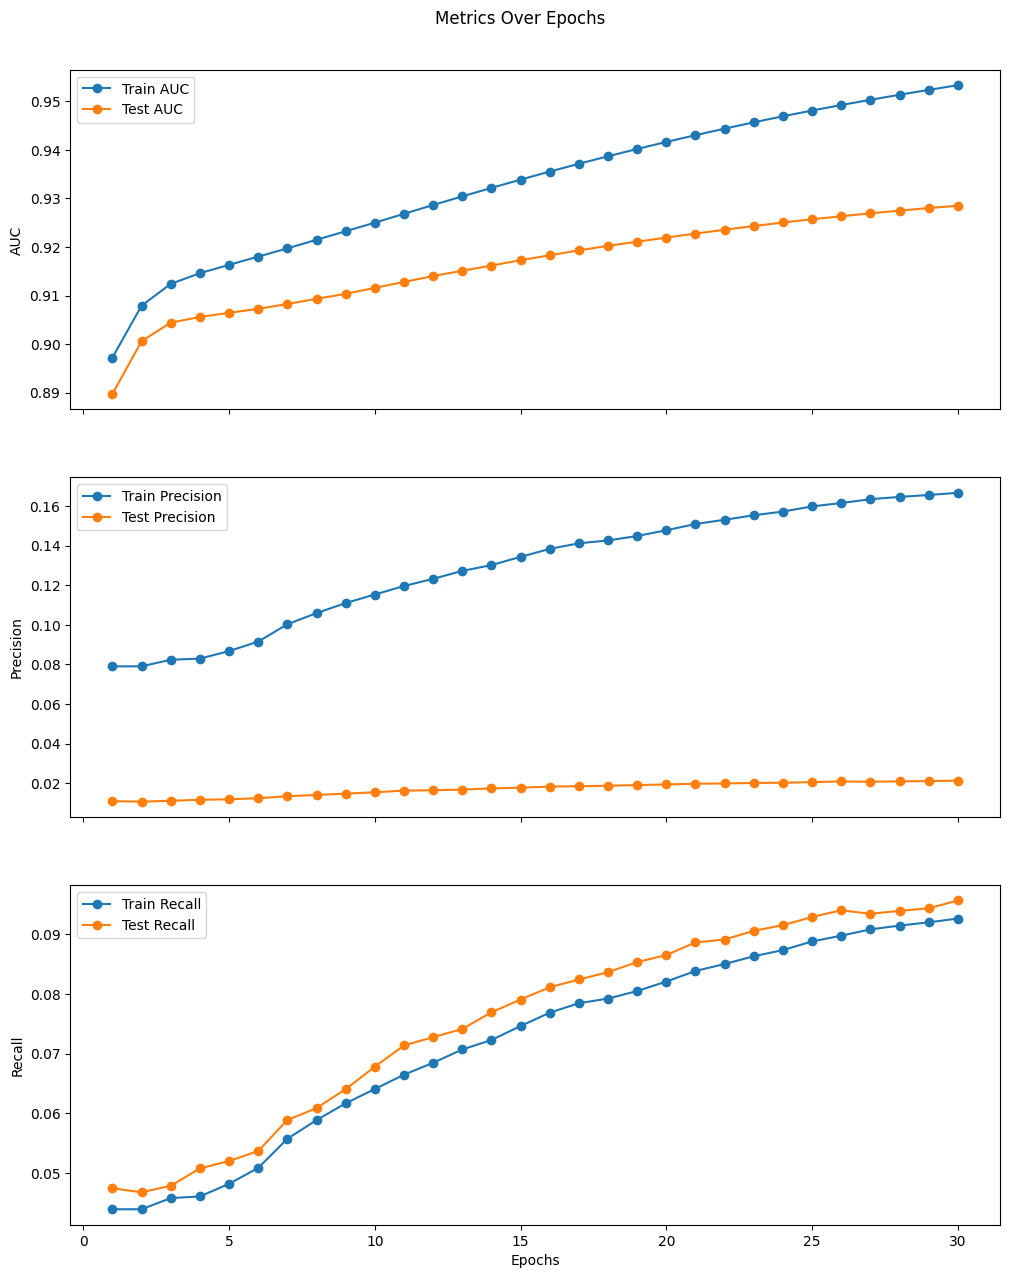

In [18]:
epochs = range(1, NO_EPOCHS + 1)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Plot AUC
axs[0].plot(epochs, train_history['AUC'], label='Train AUC', marker='o')
axs[0].plot(epochs, test_history['AUC'], label='Test AUC', marker='o')
axs[0].set_ylabel('AUC')
axs[0].legend()

# Plot Precision
axs[1].plot(epochs, train_history['Precision'], label='Train Precision', marker='o')
axs[1].plot(epochs, test_history['Precision'], label='Test Precision', marker='o')
axs[1].set_ylabel('Precision')
axs[1].legend()

# Plot Recall
axs[2].plot(epochs, train_history['Recall'], label='Train Recall', marker='o')
axs[2].plot(epochs, test_history['Recall'], label='Test Recall', marker='o')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Recall')
axs[2].legend()

plt.suptitle('Metrics Over Epochs', y=0.92)
plt.show()


In [19]:
# Evaluate precision at k on the test data
print(f'Precision@{K}: {test_history["Precision"][-1]}')
print(f'Recall@{K}: {test_history["Recall"][-1]}')
print(f'test ROC AUC: {test_history["AUC"][-1]}')

Precision@10: 0.021222122013568878
Recall@10: 0.09563446044489755
test ROC AUC: 0.9284886121749878


### **Let's see recommendation on example**

In [20]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [21]:
def sample_recommendation(model, user_ids, k):
    mapper_to_internal_ids = dataset.mapping()[2]
    mapper_to_external_ids = {v: k for k, v in mapper_to_internal_ids.items()}

    user_mapper_to_internal = dataset.mapping()[0]
    user_mapper_to_external = {v: k for k, v in user_mapper_to_internal.items()}
    user_ids = np.vectorize(user_mapper_to_internal.get)(user_ids)
    
    for user_id in user_ids:

        print(f'Games liked by user {user_mapper_to_external[user_id]}:')

        train_item_ids = [iid for uid, iid in zip(train_uids, train_iids) if uid == user_id]
        games_liked = games[games['app_id'].isin(np.vectorize(mapper_to_external_ids.get)(train_item_ids))]

        display_side_by_side(games_liked[['app_id', 'title']])

        scores = model.predict(
            int(user_id),
            list(mapper_to_internal_ids.values()),
        )
        indices = np.argsort(-scores)
        print(f'Games recommended to user {user_mapper_to_external[user_id]}:')
        games_recommended = games[games['app_id'].isin(np.vectorize(mapper_to_external_ids.get)(indices))]
        games_recommended = games_recommended[~games_recommended['app_id'].isin(games_liked['app_id'])][:k]
        display_side_by_side(games_recommended[['app_id', 'title']])



## References

In [23]:
sample_recommendation(model, np.random.choice(users['user_id'], 2), K)

Games liked by user 7510288:


,app_id,title
5,253980,Enclave
710,554620,Life is Strange: Before the Storm
1004,364470,The Elder Scrolls®: Legends™
2143,330830,Tales from the Borderlands
2169,287630,The Council
3419,320240,We Happy Few
4704,292030,The Witcher® 3: Wild Hunt
4894,1332010,Stray
5260,1091500,Cyberpunk 2077
5614,620,Portal 2


Games recommended to user 7510288:


,app_id,title
0,13500,Prince of Persia: Warrior Within™
1,113020,Monaco: What's Yours Is Mine
2,226560,Escape Dead Island
3,249050,Dungeon of the ENDLESS™
4,250180,METAL SLUG 3
6,282900,Hyperdimension Neptunia Re;Birth1
7,19810,The Sum of All Fears
8,15270,Cold Fear™
9,21130,LEGO® Harry Potter: Years 1-4
10,22130,Hearts of Iron 2 Complete


Games liked by user 11257728:


,app_id,title
523,204340,Serious Sam 2
3045,208750,Apotheon
3126,50300,Spec Ops: The Line
4279,264200,One Finger Death Punch
4843,252490,Rust
4981,22380,Fallout: New Vegas
5267,243470,Watch_Dogs™
5740,4000,Garry's Mod
6094,206190,Gunpoint
6168,204100,Max Payne 3


Games recommended to user 11257728:


,app_id,title
0,13500,Prince of Persia: Warrior Within™
1,113020,Monaco: What's Yours Is Mine
2,226560,Escape Dead Island
3,249050,Dungeon of the ENDLESS™
4,250180,METAL SLUG 3
5,253980,Enclave
6,282900,Hyperdimension Neptunia Re;Birth1
7,19810,The Sum of All Fears
8,15270,Cold Fear™
9,21130,LEGO® Harry Potter: Years 1-4


- [[1](https://arxiv.org/abs/1507.08439)]. Maciej Kula - Metadata Embeddings for User and Item Cold-start Recommendations, 2015. arXiv:1507.08439
- [[2](https://making.lyst.com/lightfm/docs/home.html)]. LightFM documentation, 
